<a href="https://colab.research.google.com/github/LautaroGelman/CienciaDeDatos/blob/main/Carbon_Regression_0_99_Test_R2_Score!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
debajyotipodder_co2_emission_by_vehicles_path = kagglehub.dataset_download('debajyotipodder/co2-emission-by-vehicles')

print('Data source import complete.')


# Carbon Regression
We want to predict the Carbon Emissions of a car based on various information such as Make, Model, and Fuel Consumption.

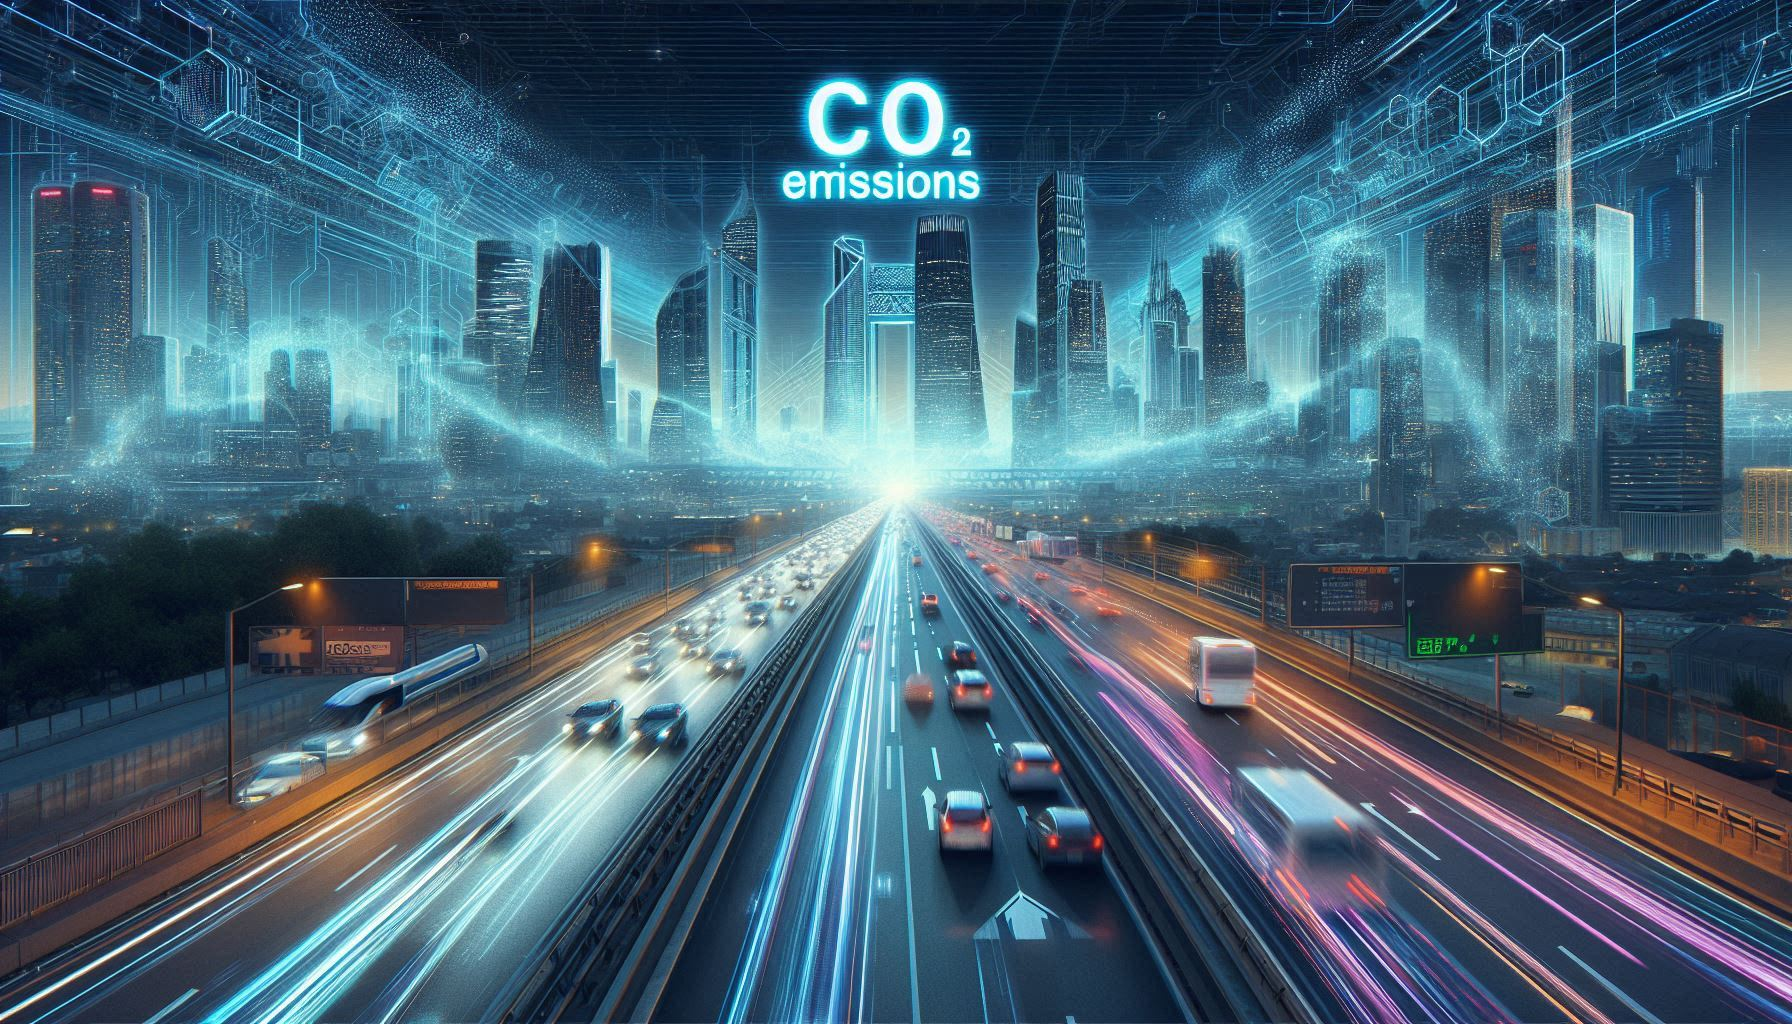

# 1. Setup and Imports

In [ ]:
!pip install pyfonts matplotlib==3.10.1 seaborn==0.13.2

## 1.1 Import Libraries

In [ ]:
import sys, os
import requests
import numpy as np
import pandas as pd

# Visualization libraries
from pyfonts import load_font
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.figsize'] = 12,8
palette = sns.color_palette("viridis", as_cmap=True)
sns.set_palette("viridis")

# Modeling libraries
import scipy as sp
import sklearn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn import set_config

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

# import mlflow

print("Python version: {}". format(sys.version))
print("NumPy version: {}". format(np.__version__))
print("pandas version: {}". format(pd.__version__))
print("matplotlib version: {}". format(mpl.__version__))
print("SciPy version: {}". format(sp.__version__))
print("scikit-learn version: {}". format(sklearn.__version__))

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))
# print(check_output(["ls", "../input/co2-emission-by-vehicles"]).decode("utf8"))

In [ ]:
# Enable MLflow's automatic experiment tracking for scikit-learn
# mlflow.sklearn.autolog()

In [ ]:
FONT_URL = "https://github.com/google/fonts/blob/0e70abe31055681b7744b8ea67f579ecda97fc0b/ofl/robotomono/RobotoMono%5Bwght%5D.ttf?raw=true"
new_default_font = load_font(
    font_url=FONT_URL,
)
mpl.font_manager.fontManager.addfont(new_default_font._file)
family = new_default_font.get_family()[0]
plt.rcParams['font.family'] = family
plt.rcParams['font.{}'.format(family)] = new_default_font.get_name()

## 1.2 Load Data

In [ ]:
# DATA_FOLDER = '../data'
DATA_FOLDER = '/kaggle/input/'
DATA_FILE_PATH = os.path.join(DATA_FOLDER, "co2-emission-by-vehicles/CO2 Emissions_Canada.csv")

In [ ]:
df = pd.read_csv(DATA_FILE_PATH)
df.head()

In [ ]:
# Global variables
RANDOM_STATE = 42

COLUMNS = df.columns.tolist()
LABEL = ['CO2 Emissions(g/km)']
NUMERICAL_FEATURES = ['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)', 'Fuel Consumption Comb (mpg)']
CATEGORICAL_FEATURES = ['Make', 'Model', 'Vehicle Class', 'Transmission', 'Fuel Type']
FEATURES_TO_SCALE = ['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)', 'Fuel Consumption Comb (mpg)']
REMAINDER_FEATURES = [feature for feature in COLUMNS if feature not in FEATURES_TO_SCALE]

# 2. EDA (Exploratory Data Analysis)

## 2.1 Data Overview
Let's check the columns, data types, counts etc.

### Domain Knowledge & Critical Thinking

Predicting CO2 emissions of ICE is important, but so is understanding CO2 emissions of Electric vehicles.

Electric vehicles are not included in this dataset for obvious reasons, but that does not mean they do not contribute to C02 emissions and other environmental pollution.

https://afdc.energy.gov/vehicles/electric-emissions

Mining rare-earth minerals for EVs results in massive amounts of carbon emissions, and also pollutes the environment in other terrible ways.

Manufacturing of a vehicle itself is a huge proportion of total carbon emissions, and it is even likely that EVs are worse for the environment unless battery technology is improved.

Building the 80kWh battery found in the Tesla Model 3 for example produces around 80% more emissions than building a comparable gasoline/petrol car.

https://climate.mit.edu/ask-mit/are-electric-vehicles-definitely-better-climate-gas-powered-cars

If the grid that powers the EV uses non-renewable sources, this exacerbates the problem. Coal has a efficiency of ~40%, add to that the transmission losses, the losses when storing the energy in the battery, and the losses when converting battery juice to mechanical energy, one can easily see how this can lead to terrible CO2 efficiency of EVs compared to gasoline vehicles.

Some things to keep in mind for the big picture.

#### Model
| Model   | Description           |
|---------|-----------------------|
| 4WD/4X4 | Four-wheel drive.     |
| AWD     | All-wheel drive       |
| FFV     | Flexible-fuel vehicle |
| SWB     | Short wheelbase       |
| LWB     | Long wheelbase        |
| EWB     | Extended wheelbase    |

#### Transmission
| Transmission | Description                 |
|--------------|-----------------------------|
| A            | Automatic                   |
| AM           | Automated manual            |
| AS           | Automatic with select shift |
| AV           | Continuously variable       |
| M            | Manual                      |
| 3 - 10       | Number of gears             |

Manual cars were generally more fuel efficient than automatic transmissions prior to 2016, however automatic transmissions have been more sophisticated in the 2010s and beyond, providing better fuel efficiency than their manual counterparts.

https://www.energy.gov/eere/vehicles/articles/fotw-1127-march-30-2020-model-year-2016-automatic-transmissions-have

#### Fuel Type
| Fuel Type | Description      |
|-----------|------------------|
| X         | Regular gasoline |
| Z         | Premium gasoline |
| D         | Diesel           |
| E         | Ethanol (E85)    |
| N         | Natural gas      |

#### Vehicle class
| Class                    | Description                                                |
|--------------------------|------------------------------------------------------------|
| COMPACT                  | Smaller vehicles, usually hatchbacks are in this category. |
| FULL-SIZE                | Larger vehicles, such as sedans.                           |
| SUV - SMALL              | Small sports utility vehicles.                             |
| MID-SIZE                 | Medium-sized cars.                                         |
| MINICOMPACT              | Very small cars.                                           |
| MINIVAN                  | Smaller-sized vans                                         |
| PICKUP TRUCK - SMALL     | Smaller-sized pickup trucks                                |
| PICKUP TRUCK - STANDARD  | Standard-sized pickup trucks                               |
| SPECIAL PURPOSE VEHICLE  | Vehicles designed for special purposes                     |
| STATION WAGON - MID-SIZE | Mid-sized station wagons                                   |
| STATION WAGON - SMALL    | Smaller-sized station wagons                               |
| SUBCOMPACT               | Smaller than compact-sized vehicles                        |
| SUV - STANDARD           | Standard-sized sports utility vehicles                     |
| TWO-SEATER               | Vehicles with two seats, usually sports cars               |
| VAN - CARGO              | Vans designed for cargo                                    |
| VAN - PASSENGER          | Vans designed for passenger transportation                 |

Smaller vehicles tend to have better fuel economy compared to larger vehicles.

https://afdc.energy.gov/data/10310


In [ ]:
df.info()

In [ ]:
df.describe()

## 2.2 Check Nulls
Let's check if we need to handle missing values or do any imputation on missing values.

In [ ]:
df.isnull().sum()

Looks like there's no null or missing values.

## 2.3 Duplication
We can move on to checking data duplication.

In [ ]:
df.sort_values(by=['Make', 'Model', 'Vehicle Class'], inplace=True)
# df = df.set_index(list(range(len(df))))
df = df.reindex(list(range(len(df))), axis=0)
mask = df.duplicated(keep=False)
duplicated_rows = df[mask]

display(df.duplicated().sum())
duplicated_rows.sort_values(by=['Make', 'Model', 'Vehicle Class'], inplace=True)
duplicated_rows.head(10)

We have quite a few duplicated rows in this dataset! Let's remove them.

In [ ]:
df.drop_duplicates(keep='first', inplace=True, ignore_index=True)
print(len(df))
df.head()

## 2.4 Data Analysis
### 2.4.1 Univariate Analysis

#### Descriptive Statistics
We can see below that the ranges of these features is a small-moderate range, and given the mean (in comparison to the range), it doesn't look like there'd be many outliers. Mean is also close to the 50% percentile, which indicates that the distributions are relatively symmetric, and fairly mean centered.

In [ ]:
df.describe()

#### Fuel Consumption City (L/100km)

In [ ]:
sns.histplot(df, x=NUMERICAL_FEATURES[2], kde=True)
plt.show()

#### Fuel Consumption Highway (L/100km)

In [ ]:
sns.histplot(df, x=NUMERICAL_FEATURES[3], kde=True)
plt.show()

#### Fuel Consumption Combined (MPG)

In [ ]:
sns.histplot(df, x=NUMERICAL_FEATURES[5], kde=True)
plt.show()

In [ ]:
plt.figure(figsize=(22, 5))
sns.countplot(df, x='Make', palette="viridis")
plt.xticks(rotation=75)
plt.show()

In [ ]:
df['Model'].value_counts(sort=True, ascending=False)

### 2.4.2 Bivariate Analysis

In [ ]:
print("Cylinder feature's unique values:", sorted(df[NUMERICAL_FEATURES[1]].unique().tolist()))
sns.histplot(df, x=NUMERICAL_FEATURES[1], palette="viridis")
plt.show()

#### Seaborn Issue / Bug?
Compare the two graphs below. Both are Violinplots with Cyclinders as the category/hue, but one has it's legend completely incorrect.

I understand that to Seaborn, the numerical value "Cylinder" looks like a continuous variable, but if so, it should show those heatmap type continuous legends.

While the graph feels "incorrect", this is the intended behavior.

Link to the issue on GitHub where I mentioned the slightly unexpected result, and got an answer from the creator of Seaborn.
https://github.com/mwaskom/seaborn/issues/3841

In [ ]:
sns.violinplot(df, y=NUMERICAL_FEATURES[2], hue=NUMERICAL_FEATURES[1], gap=0.2, palette="viridis")
plt.show()

In [ ]:
sns.violinplot(df, y=NUMERICAL_FEATURES[2], hue=NUMERICAL_FEATURES[1], gap=0.2, palette="viridis", legend="full")
plt.show()

In [ ]:
# print(df.sample(30)['Make'].tolist())
# print(df.sample(30)['Fuel Consumption City (L/100 km)'].tolist())

In [ ]:
features = NUMERICAL_FEATURES + LABEL + ['Vehicle Class']
grid = sns.pairplot(df[features], hue="Vehicle Class", palette="viridis")
# plt.xticks(rotation=45)
for ax in grid.axes.flatten():
    # rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 15)
    # ax.set_ylabel(ax.get_ylabel(), rotation = 75, x=1.0, y=0.5, rotation_mode='anchor')
    # ax.set_ylabel(ax.get_ylabel(), rotation = 75, position=(-1., 0.5), rotation_mode='anchor')
    # ax.set_ylabel(ax.get_ylabel(), rotation = 0, rotation_mode='default')
    ax.set_ylabel(ax.get_ylabel())
plt.show()

### 2.4.3 Target Variable Analysis
Let's check the distribution of the target variable.

It's a slightly right-shifted normal distribution, aka a slightly Positively skewed normal distribution.

In [ ]:
hp = sns.histplot(df, x=LABEL[0], binwidth=10, kde=True)
plt.show()

# 3. Data Preprocessing and Feature Engineering

## 3.1 Train Test Split
To prevent data leakage, split your data before performing feature engineering of any sort.

In [ ]:
train, test = model_selection.train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)
# Reset the indexes to prevent issues in concatenation, merge and other pandas methods.
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
print(len(train), len(test))
train.head()

In [ ]:
# train.to_csv("train.csv")
# test.to_csv("test.csv")

## 3.2 Feature Engineering

### 3.2.1 Feature Scaling
Let's perform feature scaling to ensure that our model converges quickly and predicts well.
#### Normalization
- This scales data to a specific range, often between 0 and 1, by adjusting values relative to the minimum and maximum of the dataset.

#### Standardization
- This transforms data to have a mean of 0 and a standard deviation of 1, by subtracting the mean and dividing by the standard deviation.

In this dataset, since all the numerical features are in the range of 0 to ~30, except for Fuel Consumption (MPG), the need for scaling is less critical. The decision should depend on the specific machie learning algorithm and the desired model performance.

In [ ]:
COLUMNS = df.columns.tolist()
FEATURES_TO_SCALE = ['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)', 'Fuel Consumption Comb (mpg)']
REMAINDER_FEATURES = [feature for feature in COLUMNS if feature not in FEATURES_TO_SCALE]

In [ ]:
robust_scaler = RobustScaler()

scaler = ColumnTransformer(
    transformers=[
        ('robust', robust_scaler, FEATURES_TO_SCALE),
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

x_train_scaled = scaler.fit_transform(train)

# # Method where you rearrange columns after transforming the columns directly, by using remainder='passthrough'.
# x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=preprocessor.get_feature_names_out())
# x_train_scaled_df = x_train_scaled_df[COLUMNS]

# Method where you drop columns while transforming the columns, and concat with remaining columns to maintain certain order.
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=scaler.get_feature_names_out())
x_train_df = pd.concat([train[REMAINDER_FEATURES], x_train_scaled_df], axis=1, sort=False)

print("Original Data:")
display(train.head())
print("\nScaled Data (using RobustScaler on specified columns):")
display(x_train_df.head())

In [ ]:
features = NUMERICAL_FEATURES + LABEL + ['Vehicle Class']
grid = sns.pairplot(x_train_df[features], hue="Vehicle Class", palette="viridis")
for ax in grid.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation = 15)
    ax.set_ylabel(ax.get_ylabel())
# grid.title("Pair Plot of Features & Label after Feature Scaling")
plt.show()

### 3.2.2 Feature Encoding

In [ ]:
train[CATEGORICAL_FEATURES].nunique()

In [ ]:
ohe_make = OneHotEncoder(sparse_output=False, dtype=int)

ohe_make.fit(train[['Make']])
print(ohe_make.categories_)

make_ohe_mat = ohe_make.transform(train[['Make']])
print(make_ohe_mat[0])
# If sparse_output = True, we need to generate the full matrix first, that's where .toarray() comes in.
# make_df = pd.DataFrame(make_ohe_mat.toarray(), columns=ohe.categories_[0])
make_df = pd.DataFrame(make_ohe_mat, columns=ohe_make.categories_[0])
make_df.head()

In [ ]:
ohe = OneHotEncoder(sparse_output=False, dtype=int)

encoder = ColumnTransformer(
    transformers=[
        ('one-hot-encoding', ohe, CATEGORICAL_FEATURES),
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

encoded_mat = encoder.fit_transform(train)

encoded_df = pd.DataFrame(encoded_mat, columns=encoder.get_feature_names_out())
# x_train_df = pd.concat([train[REMAINDER_FEATURES], encoded_df], axis=1, sort=False)
print("Original data:")
display(train[REMAINDER_FEATURES].head())
print("\nEncoded Data:")
display(encoded_df.head())

### 3.2.3 Pipeline Creation
Now that we have tried encoding and scaling column transformers, and verified the outputs, let's combine the two and create our pipeline.

#### Removing columns for dummies (Multicollinearity - Dummy variable trap)
Read more on the dummy variable trap:
- https://www.learndatasci.com/glossary/dummy-variable-trap/
- https://en.wikipedia.org/wiki/Multicollinearity

The argument `drop='first'` passed to one-hot encoders, will remove the first column, to prevent the issue of multicollinearity.

In [ ]:
robust_scaler = RobustScaler()
ohe = OneHotEncoder(sparse_output=False, dtype=int, drop='first', handle_unknown='ignore')

CT_ENCODER_NAME = 'one-hot-encoder'
CT_ROBUST_SCALER_NAME = 'robust-scaler'

column_transformer = ColumnTransformer(
    transformers=[
        (CT_ENCODER_NAME, ohe, CATEGORICAL_FEATURES),
        (CT_ROBUST_SCALER_NAME, robust_scaler, FEATURES_TO_SCALE),
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

full_pipeline = Pipeline(steps=[
    ('preprocessing', column_transformer),
])

In [ ]:
# Set the display to 'diagram'
set_config(display='diagram')

# Display the pipeline
full_pipeline

In [ ]:
# transformer = full_pipeline['preprocessing']
# ohe = transformer[CT_ENCODER_NAME]
# ohe.categories_

In [ ]:
y_train_df = train[LABEL]
y_train = y_train_df.to_numpy()
y_train = np.reshape(y_train, (-1))

x_train = full_pipeline.fit_transform(train)
print(x_train.shape)
x_train_df = pd.DataFrame(x_train, columns=full_pipeline.get_feature_names_out())
x_train_df.head()

In [ ]:
y_test_df = test[LABEL]
y_test = y_test_df.to_numpy()
y_test = np.reshape(y_test, (-1))

x_test = full_pipeline.transform(test)
x_test_df = pd.DataFrame(x_test, columns=full_pipeline.get_feature_names_out())
x_test_df.head()

# 4. Modeling

## 4.1 Linear Models
Linear models depend upon certain assumptions:
1. Linearity:
    - Linear relationship between X (independent variable) and Y (dependent variable).
    - Fuel Consumption Comb (mpg) does not have a linear relationship with CO2 emissions. Other variables do.
2. Homoscedasticity: The variance of the dependent variable is not related to the independent variable. There's no cone or changing variance.
3. Independence: The residuals are independent. There seems to be no auto-correlation between points in the dataset.
4. Normality: We can see there's multivariate normality between Fuel consumption (both City and Highway) and CO2 Emissions. We should NOT be applying a linear model if we use those features.
5. Lack of Multicollinearity: Predictors are not correlated with each other.
    - In this case, Fuel Consumption Comb is directly related to Fuel Consumption City and Fuel Consumption Hwy with the formula: Fuel Consumption Comb (L/100km) = Fuel Consumption City (L/100km) + Fuel Consumption Hwy (L/100l=km). We should either remove the combined fuel consumption and keep both the components, or keep the combined and remove the components.
6. Outlier Check: There seems to be at least one outlier which could affect the performance of the linear model. We could get rid of the outlier, but we'll need to check what the outlier is, and why it's present.

Let's train a simple Linear Regression model and evaluate it's performance.

### 4.1.1 Linear Regression from Scratch

Let's start with a small example with only 2 features

The features we'll choose are Engine Size and Fuel Consumption in the City.

In [ ]:
robust_scaler = RobustScaler()

scaler = ColumnTransformer(
    transformers=[
        ('robust', robust_scaler, FEATURES_TO_SCALE),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

x_train_scaled = scaler.fit_transform(train)
x_train_example = pd.DataFrame(x_train_scaled, columns=scaler.get_feature_names_out())

In [ ]:
y_train_example = y_train_df.to_numpy()
y_train_example = np.reshape(y_train_example, (-1))

example_features = [FEATURES_TO_SCALE[0], FEATURES_TO_SCALE[2]]
print(example_features)
x_train_example = x_train_example[example_features]
print(y_train_example.shape, x_train_example.shape)
x_train_example.head()

In [ ]:
skl_lin_reg = linear_model.LinearRegression()
skl_lin_reg.fit(x_train_example.to_numpy(), y_train_example)
y_pred = skl_lin_reg.predict(x_train_example.to_numpy())

mse = metrics.mean_squared_error(y_train_example, y_pred)

print("Sklearn LinearRegression: \nCoefficients: {}, Intercept: {}".format(skl_lin_reg.coef_, skl_lin_reg.intercept_))
print(mse)

In [ ]:
def mean_squared_error(y_truth, y_pred):
    n_samples = y_pred.shape[0]
    return np.sum(np.power((y_truth - y_pred), 2)) / n_samples


class LinearRegression:
    def __init__(self, lr=0.01, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.random.rand(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            y_pred = np.dot(X, self.weights) + self.bias

            dw = (1 / n_samples) * np.dot(X.T, y_pred - y)
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.weights = self.weights - self.lr * dw
            self.bias = self.bias - self.lr * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

In [ ]:
lin_reg = LinearRegression(lr=0.05)
lin_reg.fit(x_train_example.to_numpy(), y_train_example)
y_pred = lin_reg.predict(x_train_example.to_numpy())

mse = metrics.mean_squared_error(y_train_example, y_pred)
print("LinearRegression from Scratch: \nCoefficients: {}, Intercept: {}".format(lin_reg.weights, lin_reg.bias))
print(mse)

In [ ]:
fig = plt.figure(figsize = (5, 4))
ax = plt.axes(projection = '3d')
print(type(ax))

x = np.linspace(-1, 3, 100)
y = np.linspace(-2, 4, 100)
x, y = np.meshgrid(x, y)
eq = lin_reg.weights[0] * x + lin_reg.weights[1] * y + lin_reg.bias
# ax = fig.gca(projection='3d')
ax.plot_surface(x, y, eq, alpha=0.5)

ax.scatter3D(x_train_example[example_features[0]], x_train_example[example_features[1]], y_train_example)

plt.show()

In [ ]:
import plotly.express as px
import plotly.graph_objs as go

fig = px.scatter_3d(x_train_example, x=example_features[0], y=example_features[1], z=y_train_example)
fig.update_traces(marker_size=3)

x = np.linspace(-1, 3, 100)
y = np.linspace(-2, 4, 100)
x, y = np.meshgrid(x, y)
Z = lin_reg.weights[0] * x + lin_reg.weights[1] * y + lin_reg.bias
surf = dict(
    type='surface',
    x=x,
    y=y,
    z=Z,
    colorscale='Viridis'
)
fig.add_trace(go.Surface(x=x, y=y, z=Z, colorscale='Viridis'))

fig.show(renderer='iframe')

#### Comments
We can see that when we used two variables to predict the CO2 emissions, Linear (or Multiple Linear) Regression is fitting a line / plane / hyperplane (depending on the number of features), to the data quite well given the distribution of the data.

So, let's try fitting the model to all features.

In [ ]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(x_train, y_train)
y_pred_train = lin_reg.predict(x_train)
y_pred_test = lin_reg.predict(x_test)

train_mse = metrics.mean_squared_error(y_train, y_pred_train)
test_mse = metrics.mean_squared_error(y_test, y_pred_test)
r2_train = metrics.r2_score(y_true=y_train, y_pred=y_pred_train)
r2_test = metrics.r2_score(y_true=y_test, y_pred=y_pred_test)

print("LinearRegression: \n\tCoefficients: {}, \n\tIntercept: {}".format(lin_reg.coef_, lin_reg.intercept_))
print("MSE: \n\tTrain: \t{}, \n\tTest: \t{}".format(train_mse, test_mse))
print("R2 Score: \n\tTrain: \t{}, \n\tTest: \t{}".format(r2_train, r2_test))

### 4.1.2 Ridge Regression

In [ ]:
rr = linear_model.Ridge(alpha=0.01)
rr.fit(x_train, y_train)
y_pred_train = rr.predict(x_train)
y_pred_test = rr.predict(x_test)

train_mse = metrics.mean_squared_error(y_train, y_pred_train)
test_mse = metrics.mean_squared_error(y_test, y_pred_test)
r2_train = metrics.r2_score(y_true=y_train, y_pred=y_pred_train)
r2_test = metrics.r2_score(y_true=y_test, y_pred=y_pred_test)

print("Ridge Regression: \n\tCoefficients: {}, \n\tIntercept: {}".format(rr.coef_, rr.intercept_))
print("MSE: \n\tTrain: \t{}, \n\tTest: \t{}".format(train_mse, test_mse))
print("R2 Score: \n\tTrain: \t{}, \n\tTest: \t{}".format(r2_train, r2_test))

### 4.1.3 Lasso Regression

In [ ]:
lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(x_train, y_train)
y_pred_train = lasso.predict(x_train)
y_pred_test = lasso.predict(x_test)

train_mse = metrics.mean_squared_error(y_train, y_pred_train)
test_mse = metrics.mean_squared_error(y_test, y_pred_test)
r2_train = metrics.r2_score(y_true=y_train, y_pred=y_pred_train)
r2_test = metrics.r2_score(y_true=y_test, y_pred=y_pred_test)

print("Lasso Regression: \n\tCoefficients: {}, \n\tIntercept: {}".format(lasso.coef_, lasso.intercept_))
print("MSE: \n\tTrain: \t{}, \n\tTest: \t{}".format(train_mse, test_mse))
print("R2 Score: \n\tTrain: \t{}, \n\tTest: \t{}".format(r2_train, r2_test))

# 5. Conclusion

We used this dataset to predict CO2 emissions from vehicle information, but we could have used it to analyze fuel efficiency or just to visualize fuel efficiency by various categories. Sometimes data analysis is enough to provide key insights and drive business/policy decisions.